In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import joblib
from nltk import word_tokenize
import nltk
nltk.download('punkt')
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
nltk.download('stopwords')
from nltk.corpus import stopwords as stopwords_scratch

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import KFold

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#read data csv
df = pd.read_csv('data/train_preprocess.tsv', sep='\t', names=['Text', 'Sentiment'])
df = df.drop_duplicates()

#kamus alay
df_alay = pd.read_csv('data/new_kamusalay.csv', names=['alay', 'cleaned'], encoding='latin-1')

In [3]:
df.isna()

,Text,Sentiment
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
10993,False,False
10994,False,False
10996,False,False
10998,False,False


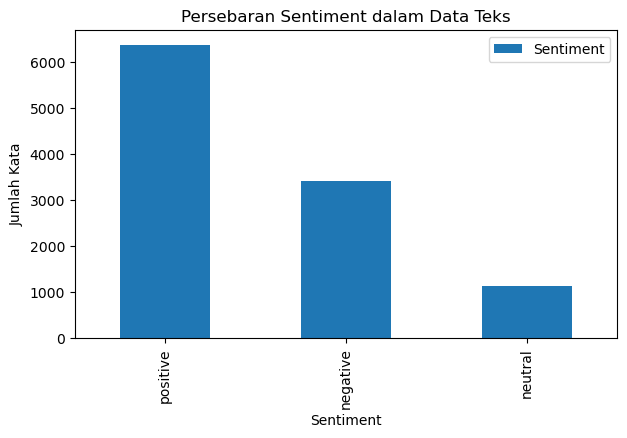

In [4]:
df['Sentiment'].value_counts().plot.bar(figsize = (7, 4))
plt.title("Persebaran Sentiment dalam Data Teks")
plt.xlabel('Sentiment')
plt.ylabel('Jumlah Kata')
plt.legend()
plt.show()

In [5]:
mapping = {
    'positive': 2,
    'neutral': 1,
    'negative': 0
}

df['label_val'] = df['Sentiment'].replace(mapping)
df['panjang_text'] = df['Text'].str.len()
df.head()

,Text,Sentiment,label_val,panjang_text
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive,2,404
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral,1,102
2,lokasi strategis di jalan sumatera bandung . t...,positive,2,184
3,betapa bahagia nya diri ini saat unboxing pake...,positive,2,93
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative,0,214


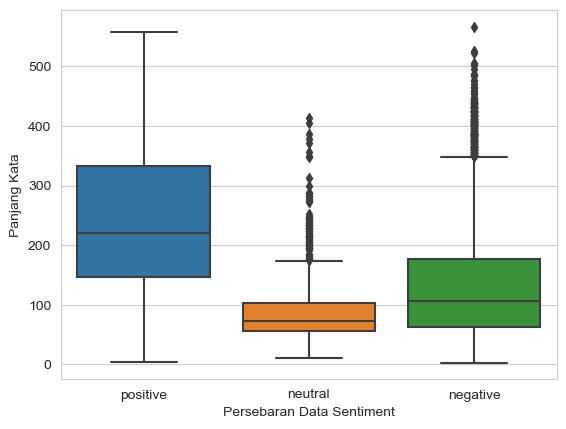

In [6]:
#visualisasi dengan whisker plot
import seaborn as sns
sns.set_style('whitegrid')
sns.boxplot(y = df['panjang_text'], x = df['Sentiment'])
plt.ylabel('Panjang Kata')
plt.xlabel('Persebaran Data Sentiment')
plt.show()

In [7]:
print(df['label_val'].describe(include=['all']))

count    10933.000000
mean         1.271746
std          0.906720
min          0.000000
25%          0.000000
50%          2.000000
75%          2.000000
max          2.000000
Name: label_val, dtype: float64


In [8]:
print('Data Distribution')
print('Mean: ', df['label_val'].mean())
print('Variance: ', df['label_val'].var())
print('Standar Deviation: ',df['label_val'].std())

Data Distribution
Mean:  1.2717460898198116
Variance:  0.8221407214732708
Standar Deviation:  0.9067197590619004


In [9]:
df_alay.head()

,alay,cleaned
0,anakjakartaasikasik,anak jakarta asyik asyik
1,pakcikdahtua,pak cik sudah tua
2,pakcikmudalagi,pak cik muda lagi
3,t3tapjokowi,tetap jokowi
4,3x,tiga kali


In [10]:
#Create Stopwords
list_stopwords = stopwords_scratch.words('indonesian')
list_stopwords_en = stopwords_scratch.words('english')
list_stopwords.extend(list_stopwords_en)
list_stopwords.extend(['ya', 'yg', 'ga', 'yuk', 'dah', 'baiknya', 'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'sekurang', 'setidak', 'tama', 'tidaknya'])

#External stopwords
f = open('stopwords/tala-stopwords-indonesia.txt', 'r')
stopword_external = []
for line in f:
    stripped_line = line.strip()
    line_list = stripped_line.split()
    stopword_external.append(line_list[0])
f.close()
list_stopwords.extend(stopword_external)

stopwords = list_stopwords

In [11]:
#Creating Function for Cleansing Process
def lowercase(text):
    return text.lower()

def special(text):
    text = re.sub(r'\W', ' ', str(text), flags=re.MULTILINE)
    return text

def single(text):
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text, flags=re.MULTILINE)
    return text

def singlestart(text):
    text = re.sub(r'\^[a-zA-Z]\s+', ' ', text, flags=re.MULTILINE)
    return text

def mulspace(text):
    text = re.sub(r'\s+', ' ', text, flags=re.MULTILINE)
    return text

#Removing RT
def rt(text):
    text = re.sub(r'rt @\w+: ', ' ', text, flags=re.MULTILINE)
    return text

#Removing prefixed 'b'
def prefixedb(text):
    text = re.sub(r'^b\s+', '', text, flags=re.MULTILINE)
    return text

def misc(text):
    text = re.sub(r'((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))|([#@]\S+)|user|\n|\t', ' ', text, flags=re.MULTILINE)
    return text

#Mapping for kamusalay
alay_mapping = dict(zip(df_alay['alay'], df_alay['cleaned']))
def alay(text):
    wordlist = text.split()
    text_alay = [alay_mapping.get(x,x) for x in wordlist]
    clean_alay = ' '.join(text_alay)
    return clean_alay

# Stopwords fuction
def stopwrds(text): 
    text_tokens = word_tokenize(text)
    tokens_without_sw = [word for word in text_tokens if not word in stopwords]
    output_sw = ' '.join(tokens_without_sw)
    return output_sw

#Function for text cleansing
def cleansing(text):
    text = lowercase(text)
    text = special(text)
    text = singlestart(text)
    text = mulspace(text)
    text = rt(text)
    text = prefixedb(text)
    text = misc(text)
    text = alay(text)
    text = stopwrds(text)
    return text

In [12]:
def stemming(text):
    word_token = word_tokenize(text)
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    input_stemm = str(word_token)
    output_stemm = stemmer.stem(input_stemm)
    stemmed_text = ' '.join(output_stemm)
    return stemmed_text

In [13]:
text = df.iloc[:,0].values
data = []
for sentence in range(0, len(text)):
    text_clean = cleansing(str(text[sentence]))
    data.append(text_clean)

df.Text = data
labels = df.iloc[:,1]
df.to_csv('data/train_preprocess_clean.csv')

In [14]:
df.head()

,Text,Sentiment,label_val,panjang_text
0,warung dimiliki pengusaha pabrik puluhan terke...,positive,2,404
1,mohon ulama lurus k212 mmbri hujjah partai diw...,neutral,1,102
2,lokasi strategis jalan sumatra bandung nya nya...,positive,2,184
3,betapa bahagia nya unboxing paket barang nya b...,positive,2,93
4,aduh mahasiswa sombong kasih kartu kuning bela...,negative,0,214


In [15]:
def hyperparam_tuning(x_train, xtest, ytrain, ytest, classifier, param_grid):
    y_train_split, y_test_split = train_test_split(y_train, test_size=0.6, random_state=0)
    #create predefined split
    ps = PredefinedSplit([-1] * ytrain_split.shape[0] + [0] * ytest_split.shape[0])
    clf = GridSearchCV(classifier, param_grid, n_jobs=-1, cv=ps)
    clf = clf.fit(xtrain, ytrain)
    return clf

def train_and_test(feature='bow', classifier='nb'):
    xtrain, xtest, ytrain, ytest = train_test_split(data, labels, test_size=0.2, random_state=0)
    #train feature on train data
    if feature == 'bow':
        vectorizer = CountVectorizer()
    elif feature == 'tfidf':
        vectorizer = TfidfVectorizer()
    else:
        raise Exception('Vectorizer unkown. Use "BoW" or "tfidf"')
    vectorizer.fit(xtrain)
    
    #transform
    xtrain = vectorizer.transform(xtrain)
    xtest = vectorizer.transform(xtest)
    
    #all classifiers
    classifier_model = {'nb' : MultinomialNB(),
                        'svm': SVC(),
                        'lr' : LogisticRegression(max_iter=1000),
                        'mlp': MLPClassifier()
                       }
    #all params for grid-search
    param_grids = {'nb' : {'alpha': np.linspace(0.001,1,50)},
                   'svm': {'C': [0.01, 0.1, 1, 10, 100], 'kernel': ['rbf', 'linear']},
                   'lr' : {'C': np.linspace(0.001,10,100)},
                   'mlp': {'activation':['relu']}
                  }
    
    #hyperparam_tuning used for model besides MLP, since MLP works better without hyperparameter
    model = MLPClassifier()
    clf = model.fit(xtrain, ytrain)
    pred = clf.predict(xtest.toarray())
    f1 = f1_score(ytest,pred, average='micro')
    
    return f1, clf, vectorizer, pred, xtrain, xtest, ytrain, ytest

In [16]:
input_sentiment = "woi jelek banget lu"
print(f"Training for sentiment analysis classifier")
f1, clf, vectorizer, pred, xtrain, xtest, ytrain, ytest = train_and_test(feature='tfidf', classifier='mlp')
print(f"Training done. F1 on test set is {f1}")

input_sentiment = " ".join(word_tokenize(input_sentiment))
sent = clf.predict(vectorizer.transform([input_sentiment]).toarray())
print(f"\nSentiment on the input text is {sent}")

Training for sentiment analysis classifier
Training done. F1 on test set is 0.8065843621399177

Sentiment on the input text is ['negative']


In [17]:
print(classification_report(ytest,pred))

              precision    recall  f1-score   support

    negative       0.72      0.76      0.74       689
     neutral       0.76      0.60      0.67       236
    positive       0.86      0.87      0.87      1262

    accuracy                           0.81      2187
   macro avg       0.78      0.74      0.76      2187
weighted avg       0.81      0.81      0.81      2187



In [18]:
joblib.dump(f1,'score.pkl')
joblib.dump(clf,'model.pkl')
joblib.dump(vectorizer,'vectorizer.pkl')

['vectorizer.pkl']

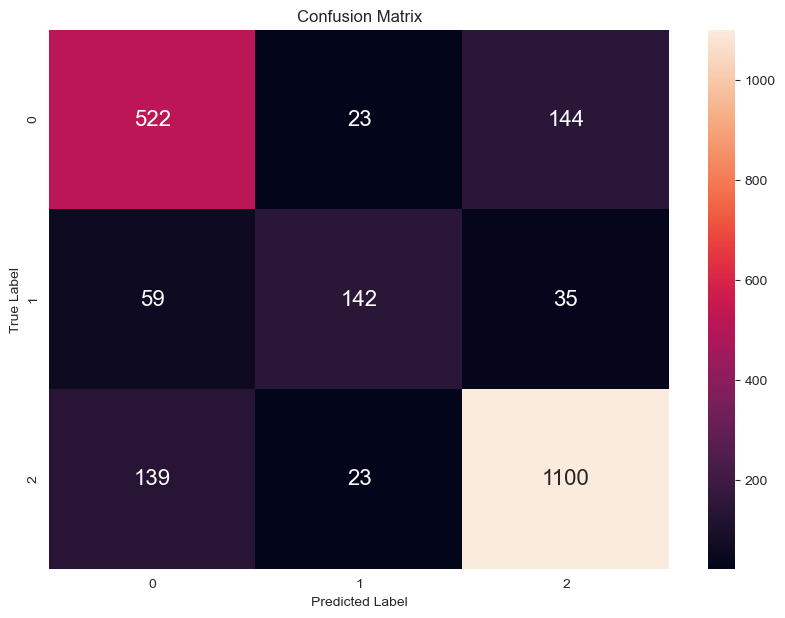

In [19]:
def plot_confusion_matrix(ytest,pred):
    conf_mat = pd.DataFrame(confusion_matrix(ytest, pred))
    fig = plt.figure(figsize=(10,7))
    sns.heatmap(conf_mat, annot=True, annot_kws={'size':16}, fmt='g')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

plot_confusion_matrix(ytest, pred)

In [21]:
kf = KFold(n_splits=5, random_state=42, shuffle=True)
accuracies = []
vectorizer.fit(df.iloc[:,0])
x = vectorizer.transform(df.iloc[:,0])
y = labels.values

for iteration, datas in enumerate(kf.split(x), start=1):
    data_train = x[datas[0]]
    target_train = y[datas[0]]
    
    data_test = x[datas[1]]
    target_test = y[datas[1]]
    
    clf = MLPClassifier()
    clf.fit(data_train, target_train)
    preds = clf.predict(data_test)
    accuracy = accuracy_score(target_test, preds)
    
    print('Training no: ', iteration)
    print(classification_report(target_test, preds))
    print("======================================================")
    
    accuracies.append(accuracy)

average_accuracy = np.mean(accuracies)

print()
print()
print()
print('Average Accuracy: ', average_accuracy)

Training no:  1
              precision    recall  f1-score   support

    negative       0.72      0.77      0.75       690
     neutral       0.78      0.55      0.64       220
    positive       0.86      0.87      0.87      1277

    accuracy                           0.81      2187
   macro avg       0.79      0.73      0.75      2187
weighted avg       0.81      0.81      0.81      2187

Training no:  2
              precision    recall  f1-score   support

    negative       0.71      0.74      0.72       667
     neutral       0.78      0.57      0.66       219
    positive       0.86      0.88      0.87      1301

    accuracy                           0.81      2187
   macro avg       0.78      0.73      0.75      2187
weighted avg       0.81      0.81      0.80      2187

Training no:  3
              precision    recall  f1-score   support

    negative       0.75      0.73      0.74       695
     neutral       0.79      0.61      0.69       213
    positive       0.85    